# 04. Final Model Evaluation Pipeline

## Objective
The purpose of this notebook is to conduct the final, rigorous evaluation of the diagnostic model for predicting Ulcerative Colitis severity (Mayo Score). Based on the comparative benchmarks performed in previous experiments (`03_Experiment.ipynb`), we have identified the optimal data processing pipeline.

## Reason for this Notebook
In the previous experimental phase, we tested multiple imputation methods (KNN, MICE, GAIN) and synthetic data generators (CTGAN, TVAE, ADASYN). The results indicated that **MICE imputation** combined with **TVAE (Tabular Variational Autoencoder)** augmentation yielded the highest predictive performance.

This notebook isolates that specific high-performing configuration to generate the final metrics and visualizations for the research report. It ensures a clean separation between the training process (on augmented data) and the evaluation (strictly on real, unseen patient data) to prevent data leakage.

## Methodology
1.  **Data Loading:** Load the `MICE` imputed dataset (Real Data) and the `TVAE` synthetic dataset.
2.  **Data Splitting:** Isolate 20% of the real patient data as a held-out Test Set. This set remains untouched by synthetic data.
3.  **Augmentation:** Merge the remaining 80% of real training data with the synthetic TVAE data.
4.  **Modeling:** Train a Stacking Ensemble (Random Forest + CatBoost with a Logistic Regression meta-learner) on the augmented training set.
5.  **Validation:** Evaluate the model on the held-out real test set and generate the official Confusion Matrix.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define file paths
real_path = '../data/processed/uc_diagnostic_tests_mice.csv'
synth_path = '../data/synthetic/mice/uc_diagnostics_tvae.csv'

# Helper function to clean data
def safe_clean(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = df[col].str.replace(',', '.').astype(float)
            except ValueError:
                pass
    return df

In [2]:
# Load Real Data
if os.path.exists(real_path):
    print(f"Loaded Real Data: {real_path}")
    df_real = pd.read_csv(real_path)
    df_real = safe_clean(df_real)
else:
    raise FileNotFoundError(f"File not found: {real_path}")

# Prepare Features and Target
target_col = 'mayo'
X = df_real.drop(columns=[target_col])
y = df_real[target_col]


# We use stratify to maintain the balance of classes
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Loaded Real Data: ../data/processed/uc_diagnostic_tests_mice.csv


In [3]:
# Load Synthetic Data
if os.path.exists(synth_path):
    print(f"Loaded Synthetic Data: {synth_path}")
    df_synth = pd.read_csv(synth_path)
    df_synth = safe_clean(df_synth)

    # Align columns to ensure order matches the real data
    X_synth = df_synth[X_train_real.columns]
    y_synth = df_synth[target_col]

    # Combine: Real Train + All Synthetic
    X_train_augmented = pd.concat([X_train_real, X_synth], axis=0)
    y_train_augmented = pd.concat([y_train_real, y_synth], axis=0)

    print(f"Augmentation Result: {len(X_train_real)} Real + {len(X_synth)} Synthetic Patients")
    print(f"Total Training Size: {len(X_train_augmented)}")
else:
    raise FileNotFoundError(f"File not found: {synth_path}")

Loaded Synthetic Data: ../data/synthetic/mice/uc_diagnostics_tvae.csv
Augmentation Result: 201 Real + 504 Synthetic Patients
Total Training Size: 705


In [4]:
print("Training Stacking Model on Augmented Data...")

# Initialize Base Learners
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
cb = CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False, thread_count=1)

# Initialize Stacking Ensemble
stack = StackingClassifier(
    estimators=[('rf', rf), ('cb', cb)],
    final_estimator=LogisticRegression(),
    n_jobs=1
)

# Train the model
stack.fit(X_train_augmented, y_train_augmented)
print("Training Complete.")

Training Stacking Model on Augmented Data...
Training Complete.


Generating Plot...
Image saved as 'confusion_matrix_final.png'. Open the file folder to see it!


<Figure size 800x600 with 0 Axes>

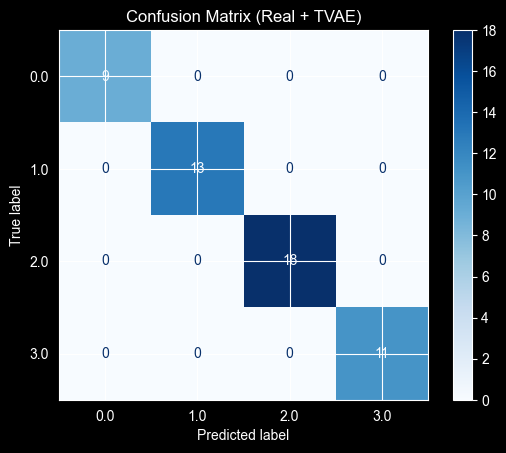

In [5]:
print("Generating Plot...")

# Predict on the hidden real test set
y_pred = stack.predict(X_test_real)
cm = confusion_matrix(y_test_real, y_pred)

# Create the plot
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title("Confusion Matrix (Real + TVAE)")

# Save the figure
filename = "confusion_matrix_final.png"
plt.savefig(filename)
print(f"Image saved as '{filename}'. Open the file folder to see it!")